<a href="https://colab.research.google.com/github/donnadamus/mlinapplabs/blob/main/5_DL_Transfer_learning_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Transfer learning.

Thanks to their capability to learn generalizable descriptors directly from images, deep Convolutional Neural Networks (CNNs) seem the ideal solution to most pattern recognition problems. On the other hand, to learn the image representation, CNNs need huge sets of annotated samples that are unfeasible in many every-day scenarios. This is the case, for example, of Computer-Aided Diagnosis (CAD) systems for digital pathology, where additional challenges are
posed by the high variability of the cancerous tissue characteristics.
In this notebooks you are going to implement 3 different training paradigms leveraging CNNs:


1.   Training from scratch
2.   Features extractor followed by SVM
3.   Fine tuning




# Import and settings

In [ ]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
!git clone https://github.com/frpnz/dataset-BIOSTEC2018.git
ROOTDIR_DATASET = "/content/dataset-BIOSTEC2018/crc_images"
IMAGE_SIZE = 32
NUM_CLASSES = 3

Cloning into 'dataset-BIOSTEC2018'...
remote: Enumerating objects: 13518, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13518 (delta 1), reused 6 (delta 1), pack-reused 13512
Receiving objects: 100% (13518/13518), 1.87 GiB | 13.41 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (13501/13501), done.


## Utils

In [ ]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Assignment #1: create two tensorflow dataset for train and test.
Leverage the API [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "train"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "test"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


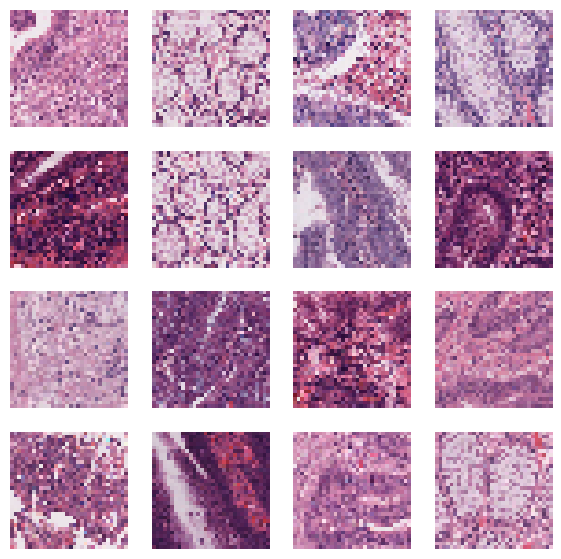

In [ ]:
j = 0
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
ax = ax.ravel()
for batch in train_ds.take(1):
    images = batch[0]
    labels = batch[1]
    for image, label in zip(images, labels):
        if j >= 16:
            break
        image = image.numpy().astype(np.uint8)
        ax[j].imshow(image)
        ax[j].axis("off")
        j += 1

# Assignment #2: dataset preparation
1.   Normalize images in the range [0, 1]
2.   Prepare the input pipeline via tf.data.Dataset methods



In [ ]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., label

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(100).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# Assignment #3: train a VGG16 from scratch for 50 epochs

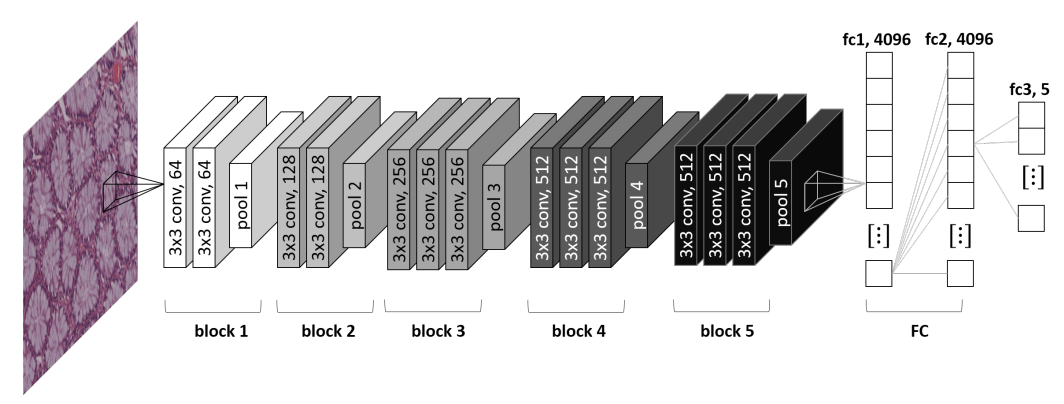

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling=None,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
def scheduler(epoch, lr):
    if epoch < 45:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
vgg16.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = vgg16.fit(train_ds, epochs=50, callbacks=[callback])

Epoch 1/50
282/282 [==============================] - 43s 94ms/step - loss: 1.0985 - accuracy: 0.3426 - lr: 0.0100
Epoch 2/50
282/282 [==============================] - 9s 31ms/step - loss: 1.0981 - accuracy: 0.3549 - lr: 0.0100
Epoch 3/50
282/282 [==============================] - 9s 31ms/step - loss: 1.0972 - accuracy: 0.3702 - lr: 0.0100
Epoch 4/50
282/282 [==============================] - 8s 30ms/step - loss: 1.0942 - accuracy: 0.4854 - lr: 0.0100
Epoch 5/50
282/282 [==============================] - 9s 31ms/step - loss: 1.0761 - accuracy: 0.6028 - lr: 0.0100
Epoch 6/50
282/282 [==============================] - 9s 30ms/step - loss: 0.9844 - accuracy: 0.5704 - lr: 0.0100
Epoch 7/50
282/282 [==============================] - 9s 31ms/step - loss: 0.7812 - accuracy: 0.6411 - lr: 0.0100
Epoch 8/50
282/282 [==============================] - 9s 30ms/step - loss: 0.6858 - accuracy: 0.6876 - lr: 0.0100
Epoch 9/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6041 - acc

In [ ]:
print("Accuracy on test set: {:.2f}".format(vgg16.evaluate(test_ds)[1]))

141/141 [==============================] - 16s 100ms/step - loss: 0.2425 - accuracy: 0.9171
Accuracy on test set: 0.92


## Plot train loss and accuracy among epochs (see [History](tf.keras.callbacks.History) object)

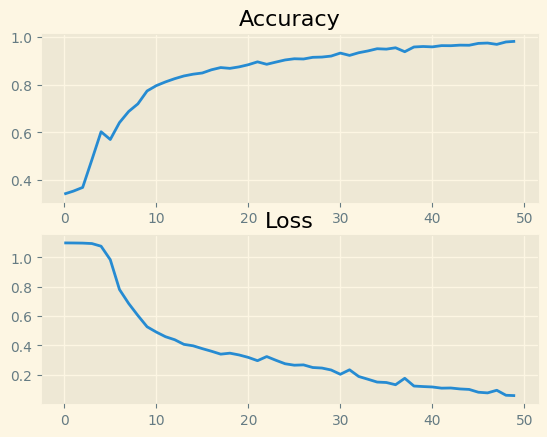

In [ ]:
plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(2, 1)
ax[0].plot([e for e in range(history.params['epochs'])], history.history['accuracy'])
ax[0].set_title("Accuracy");
ax[1].plot([e for e in range(history.params['epochs'])], history.history['loss'])
ax[1].set_title("Loss");

# Assignment #4: extract features from VGG16 pre-trained on ImageNet and then train and test a downstream SVM.

Pipeline:
1. Features extraction from the CNN
2. PCA
3. SVM training and test

N.B. Do not shuffle train and test in order to extract labels in the correct order.


So, to clarify, the pre-trained VGG16 model is used as a "feature transformer" or "feature mapper" to map your biological images into a space of features that were learned during its training on imagenet.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "train"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "test"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [ ]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return  tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling="avg",
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
"""
In transfer learning, we often remove the top layer(s) of a pre-trained neural network because these layers are typically specialized in recognizing high-level features that are specific to the original task the network was trained on. By removing these layers, we retain the lower layers, which capture more generic features like edges, textures, and shapes. These lower layers are often valuable for recognizing similar features in a new task.

After removing the top layers, we replace them with a new classifier, such as a Support Vector Machine (SVM), to adapt the pre-trained model to the new task. SVMs are a popular choice for this purpose because they are effective for classification tasks, even when dealing with high-dimensional data. SVMs can learn decision boundaries that separate different classes in the feature space defined by the output of the pre-trained network's lower layers.

By combining the generic feature representations learned by the pre-trained network with a new classifier trained specifically for the new task, transfer learning allows us to leverage knowledge from the original task and adapt it to a related task with potentially less labeled data and computational resources. This approach often leads to faster convergence and better performance compared to training a model from scratch.
"""

"\nIn transfer learning, we often remove the top layer(s) of a pre-trained neural network because these layers are typically specialized in recognizing high-level features that are specific to the original task the network was trained on. By removing these layers, we retain the lower layers, which capture more generic features like edges, textures, and shapes. These lower layers are often valuable for recognizing similar features in a new task.\n\nAfter removing the top layers, we replace them with a new classifier, such as a Support Vector Machine (SVM), to adapt the pre-trained model to the new task. SVMs are a popular choice for this purpose because they are effective for classification tasks, even when dealing with high-dimensional data. SVMs can learn decision boundaries that separate different classes in the feature space defined by the output of the pre-trained network's lower layers.\n\nBy combining the generic feature representations learned by the pre-trained network with a n

In [ ]:
features_train = vgg16.predict(train_ds)
features_test = vgg16.predict(test_ds)

141/141 [==============================] - 15s 104ms/step


In [ ]:
labels_train = np.concatenate([np.argmax(y, axis=1) for _, y in train_ds], axis=0)
labels_test = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

In [ ]:
features_train.shape
# The shape of this vector corresponds to the number of filters in the last convolutional layer of VGG16, which is 512.

(9000, 512)

In [ ]:
pca = PCA()
features_train_pca = pca.fit_transform(features_train)
features_test_pca = pca.transform(features_test)

In [ ]:
features_train_pca.shape

(9000, 512)

## Explained variance

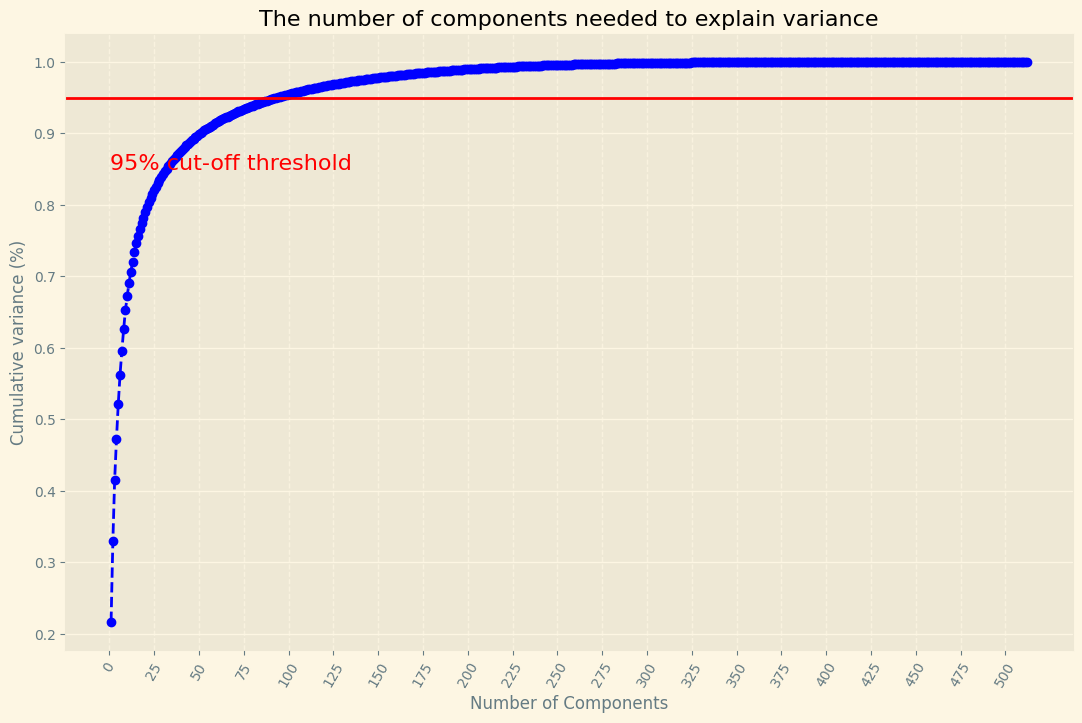

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
xi = np.arange(1, features_train_pca.shape[1] + 1, step=1)
y = pca.explained_variance_ratio_.cumsum()

ax.plot(xi, y, marker='o', linestyle='--', color='b')

ax.set_xlabel('Number of Components')
ax.set_xticks(np.arange(0, features_train_pca.shape[1] + 1, step=25))
ax.set_xticklabels(np.arange(0, features_train_pca.shape[1] + 1, step=25), rotation=60)
ax.set_ylabel('Cumulative variance (%)')
ax.set_title('The number of components needed to explain variance')

ax.axhline(y=0.95, color='r', linestyle='-')
ax.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x',
        alpha=0.75,
        linestyle='--')

In [ ]:
from sklearn.svm import SVC
clf = SVC()

random_grid_svm = {"kernel": ["rbf"],
                    "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
                    "class_weight": [None, "balanced"],
                    "C": [0.01, 0.1, 1]}
search = RandomizedSearchCV(estimator=SVC(),
                            param_distributions=random_grid_svm,
                            scoring="balanced_accuracy",
                            n_iter=2,
                            cv=2,
                            verbose=1,
                            random_state=42,
                            n_jobs=-1)
search.fit(features_train_pca[:, :100], labels_train)
clf = search.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
preds_test = clf.predict(features_test_pca[:, :100])

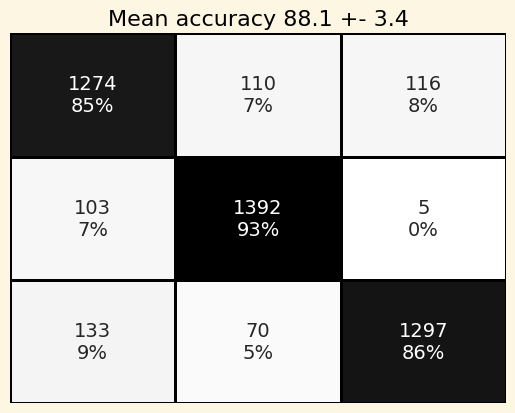

In [ ]:
fig, ax = plt.subplots(1, 1)
cm = confusion_matrix(labels_test, preds_test, labels=[0, 1, 2])
seaborn_cm(cm, ax, [0, 1, 2])

# Assignment #5: Fine tune the VGG16 pre-trained on ImageNet.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "train"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOTDIR_DATASET, "test"),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [ ]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return  tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling=None,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(f"layer {i}: {layer.name}")

layer 0: input_3
layer 1: block1_conv1
layer 2: block1_conv2
layer 3: block1_pool
layer 4: block2_conv1
layer 5: block2_conv2
layer 6: block2_pool
layer 7: block3_conv1
layer 8: block3_conv2
layer 9: block3_conv3
layer 10: block3_pool
layer 11: block4_conv1
layer 12: block4_conv2
layer 13: block4_conv3
layer 14: block4_pool
layer 15: block5_conv1
layer 16: block5_conv2
layer 17: block5_conv3
layer 18: block5_pool


In [ ]:
for i, layer in enumerate(base_model.layers):
    if i > 10:
        layer.trainable = True
    else:
        layer.trainable = False

# freezing layer weights from 0 to 10

In [ ]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs)
x = tf. keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 45:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_ds, epochs=50,callbacks=[callback])

Epoch 1/50
282/282 [==============================] - 33s 108ms/step - loss: 0.7935 - accuracy: 0.7687 - lr: 0.0010
Epoch 2/50
282/282 [==============================] - 7s 27ms/step - loss: 0.4163 - accuracy: 0.8731 - lr: 0.0010
Epoch 3/50
282/282 [==============================] - 7s 26ms/step - loss: 0.2034 - accuracy: 0.9274 - lr: 0.0010
Epoch 4/50
282/282 [==============================] - 7s 25ms/step - loss: 0.1328 - accuracy: 0.9512 - lr: 0.0010
Epoch 5/50
282/282 [==============================] - 7s 25ms/step - loss: 0.1007 - accuracy: 0.9653 - lr: 0.0010
Epoch 6/50
282/282 [==============================] - 7s 25ms/step - loss: 0.0881 - accuracy: 0.9704 - lr: 0.0010
Epoch 7/50
282/282 [==============================] - 7s 25ms/step - loss: 0.0637 - accuracy: 0.9786 - lr: 0.0010
Epoch 8/50
282/282 [==============================] - 7s 26ms/step - loss: 0.0492 - accuracy: 0.9844 - lr: 0.0010
Epoch 9/50
282/282 [==============================] - 7s 24ms/step - loss: 0.0725 - ac

In [ ]:
print("Accuracy on test set: {:.2f}".format(model.evaluate(test_ds)[1]))

141/141 [==============================] - 14s 94ms/step - loss: 0.5571 - accuracy: 0.9247
Accuracy on test set: 0.92
